LENDING - RF Version (c) Daniele Marazzina

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc, average_precision_score

In [2]:
df = pd.read_excel('lendingclub_fulldata.xlsx')
# 1 = good, 0 = default

# splitting in training, validation and test...
train_predictors, rest_predictors, train_response, rest_response = train_test_split(
       df.drop('loan_status', axis=1), df['loan_status'], train_size=0.7, random_state=0)

validation_predictors, test_predictors, validation_response, test_response = train_test_split(
rest_predictors, rest_response, train_size=0.5, random_state=0)

In [3]:
for i in range(10):
    # model definition + training
    n_estimators = 10*(i+1)
    max_depth = 10*(i+1)
    min_samples_split = 4*(i+1)
    min_samples_leaf = 4*(i+1)
    min_impurity_decrease = 0
    parameters = {"n_estimators": n_estimators,
      "max_depth": max_depth,
      "min_samples_split": min_samples_split,
      "min_samples_leaf": min_samples_leaf,
      "min_impurity_decrease": min_impurity_decrease,
      "random_state": 0,
       }
    classifier = RandomForestClassifier(**parameters)
    classifier.fit(train_predictors, train_response)
    # Compute the ROC curve and AUC
    y_val = validation_response
    Q = classifier.predict_proba(validation_predictors)[:,1]
    fpr, tpr, _ = roc_curve(y_val, Q)
    roc_auc = auc(fpr,tpr)
    print('hyperparameters set %d - AUC = %0.4f' % (i, roc_auc))

hyperparameters set 0 - AUC = 0.6087
hyperparameters set 1 - AUC = 0.5967
hyperparameters set 2 - AUC = 0.5975
hyperparameters set 3 - AUC = 0.6127
hyperparameters set 4 - AUC = 0.6105
hyperparameters set 5 - AUC = 0.6103
hyperparameters set 6 - AUC = 0.6150
hyperparameters set 7 - AUC = 0.6159
hyperparameters set 8 - AUC = 0.6140
hyperparameters set 9 - AUC = 0.6162


In [4]:
# Measure overall quality of our classifier

In [5]:
i=7
n_estimators = 10*(i+1)
max_depth = 10*(i+1)
min_samples_split = 4*(i+1)
min_samples_leaf = 4*(i+1)
min_impurity_decrease = 0
parameters = {"n_estimators": n_estimators,
      "max_depth": max_depth,
      "min_samples_split": min_samples_split,
      "min_samples_leaf": min_samples_leaf,
      "min_impurity_decrease": min_impurity_decrease,
      "random_state": 0,
       }
classifier = RandomForestClassifier(**parameters)
classifier.fit(train_predictors, train_response)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=80, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=32,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [6]:
y_test = test_response
y_pred = classifier.predict(test_predictors)

In [7]:
THRESHOLD = [.5, .75, .80, .85]
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "recall", "tnr", "fpr", "precision", "f1_score"]) # df to store results
results['THRESHOLD'] = THRESHOLD                                                                           # threshold column
n_test = len(y_test)
Q = classifier.predict_proba(test_predictors)[:,1]
j = 0                                                                                                      
for i in THRESHOLD:                                                                                        # iterate over each threshold        
                                                                         # fit data to model
    preds = np.where(Q>i, 1, 0)                                       # if prob > threshold, predict 1
    
    cm = (confusion_matrix(y_test, preds,labels=[1, 0], sample_weight=None)/n_test)*100 
    # confusion matrix (in percentage)
    
    print('Confusion matrix for threshold =',i)
    print(cm)
    print(' ')      
    
    TP = cm[0][0]                                                                                          # True Positives
    FN = cm[0][1]                                                                                          # False Positives
    FP = cm[1][0]                                                                                          # True Negatives
    TN = cm[1][1]                                                                                          # False Negatives
        
    results.iloc[j,1] = accuracy_score(y_test, preds) 
    results.iloc[j,2] = recall_score(y_test, preds)
    results.iloc[j,3] = TN/(FP+TN)                                                                         # True negative rate
    results.iloc[j,4] = FP/(FP+TN)                                                                         # False positive rate
    results.iloc[j,5] = precision_score(y_test, preds)
    results.iloc[j,6] = f1_score(y_test, preds)
   
    j += 1

print('ALL METRICS')
print(results.T.to_string(header=False))

Confusion matrix for threshold = 0.5
[[83.07481752  0.        ]
 [16.92518248  0.        ]]
 
Confusion matrix for threshold = 0.75
[[71.21350365 11.86131387]
 [13.04744526  3.87773723]]
 
Confusion matrix for threshold = 0.8
[[55.83941606 27.23540146]
 [ 9.16970803  7.75547445]]
 
Confusion matrix for threshold = 0.85
[[37.22627737 45.84854015]
 [ 5.38321168 11.5419708 ]]
 
ALL METRICS
THRESHOLD       0.5      0.75       0.8      0.85
accuracy   0.830748  0.750912  0.635949  0.487682
recall            1  0.857221  0.672158  0.448105
tnr               0  0.229111  0.458221  0.681941
fpr               1  0.770889  0.541779  0.318059
precision  0.830748  0.845154  0.858947  0.873662
f1_score    0.90755  0.851145  0.754159  0.592377


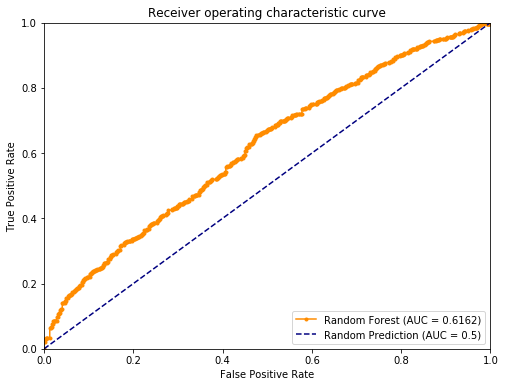

In [8]:
plt.figure(figsize=(8,6))      # format the plot size
lw = 1.5
plt.plot(fpr, tpr, color='darkorange', marker='.',
         lw=lw, label='Random Forest (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--',
         label='Random Prediction (AUC = 0.5)' )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()